In [1]:
%matplotlib inline
import os
import sys
import random

import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/Shareddrives/Deep Learning/DeepLearning_2022/Final Project/Data/'
results_path = '/content/drive/Shareddrives/Deep Learning/DeepLearning_2022/Final Project/Results/'
sys.path.append('/content/drive/Shareddrives/Deep Learning/DeepLearning_2022/Final Project/midi')

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import torch.utils.data as data
from torch.autograd import Variable

from utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


Mounted at /content/drive


In [2]:
%%script echo skipping
a = 3

skipping


# DataLoader

In [3]:
def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Pressed notes are replaced by 1
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
        
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll

    return padded_piano_roll

In [4]:
class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # Shifting by one time step
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifting by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # padding sequence so that all of them have the same length
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,max_length=self.longest_sequence_length,pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),torch.LongTensor(ground_truth_sequence_padded),torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [5]:
trainset = NotesGenerationDataset(data_path + '/Nottingham/train/', longest_sequence_length=None)

trainset_loader = data.DataLoader(trainset, batch_size=8,shuffle=True, drop_last=True)

In [6]:
X = next(iter(trainset_loader))
X[0].shape

torch.Size([8, 1491, 88])

In [7]:
valset = NotesGenerationDataset(data_path + '/Nottingham/valid/', longest_sequence_length=None)

valset_loader = data.DataLoader(valset, batch_size=8, shuffle=False, drop_last=False)

In [8]:
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([8, 1229, 88])

# LSTM

In [9]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [10]:
model = RNN(input_size=88, hidden_size=512, num_classes=88).cuda()

criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss().cuda()

In [11]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [12]:
validate(model)

8.41491462212453e-06

In [13]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [14]:
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(rnn.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)

            optimizer.step()
        print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0
Epoch 1


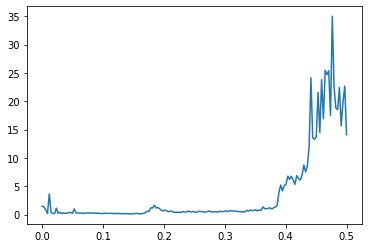

In [15]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader)

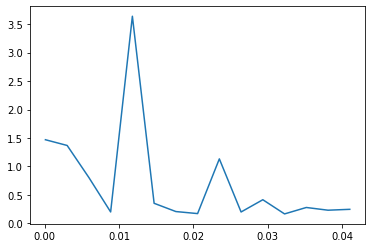

In [16]:
plt.plot(lrs[:15], losses[:15])

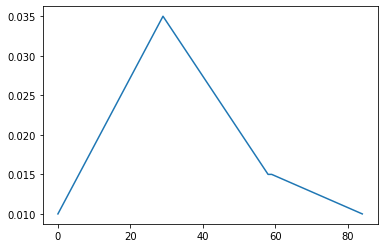

In [17]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
plt.plot(lrs_triangular)

In [18]:
clip = 1.0

In [19]:
def train_model(model, lrs_triangular, epochs_number=2, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for lr, batch in zip(lrs_triangular, trainset_loader):
            optimizer.param_groups[0]['lr'] = lr

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [20]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular)

Training Loss: Epoch: 0 : 0.2258114146805087
Validation Loss: Epoch: 0 : 7.387781365614333e-07

Training Loss: Epoch: 1 : 0.10174081145330917
Validation Loss: Epoch: 1 : 6.866459451336118e-07



In [21]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.09904492967004
Validation Loss: Epoch: 0 : 6.104699925206434e-07

Training Loss: Epoch: 1 : 0.09391626984227536
Validation Loss: Epoch: 1 : 6.007683575161921e-07



In [22]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.09772975898759309
Validation Loss: Epoch: 0 : 6.131783371627626e-07

Training Loss: Epoch: 1 : 0.09939554056455922
Validation Loss: Epoch: 1 : 6.376460338094019e-07



In [23]:
rnn.load_state_dict(torch.load('music_model_padfront_regularized.pth'))

<All keys matched successfully>

In [24]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

In [25]:
testset = NotesGenerationDataset(data_path + '/Nottingham/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [26]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var.shape

torch.Size([160, 1, 88])

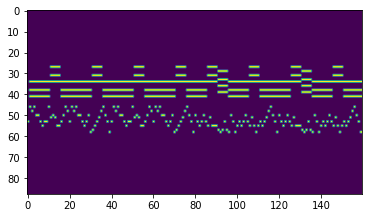

In [27]:
plt.imshow(input_sequences_batch_var.reshape((input_sequences_batch_var.shape[0],88)).transpose(0,1).cpu())

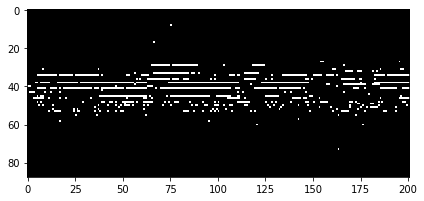

In [28]:
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite(f'{results_path}resultLSTM.mid', sample.transpose(), dt=0.3)